# Actor Critic

The Actor-Critic algorithm combines Policy Gradient and DQN. It includes two networks: Actor and Critic. The actor learns the policy and decides which action should be taken, and it is updated using Policy Gradient. The critic estimates the value function and informs the actor how good the action was and how it should be adjusted, which is represented by a Deep Q Network.

Similar to the intention of the baseline method introduced in Policy Gradient, we want to mitigate the variations caused by random variables in the training process. Therefore, we can try to substitute $G_t$ with its expected value, the state value function $Q_\pi\left(s_t, a_t\right)$. By rewriting it using $Q_\pi\left(s_t, a_t\right)=r_t+V_\pi\left(s_{t+1}\right)$ and representing the baseline as $V_\pi\left(s_{t}^n\right)$, we have the following equation:

\begin{align*}
\nabla_\theta J(\theta) \approx \mathbb{E}_{\pi_\theta}
\left[ \sum_{t=0}^{T-1} A \left( s_t, a_t\right) \nabla_\theta \log \pi_\theta(a_t \ |\ s_t) \right]
\end{align*}

where the advantage value represents $ A \left( s_t, a_t\right) = r_t+V_\pi\left(s_{t+1}\right)-V_\pi\left(s_t\right)$ The advantage function captures how better an action is compared to the others at a given state. In this way, we substitute $G_t$ with a high variance using $r_t$ with a smaller variance to stabilize the model.

There is always a trade-off between variance and bias (introduced by the value functions). To balance them, we may explore $A \left( s_t, a_t\right) = \sum_{t^{\prime}=t+1}^{t+1+n} \gamma^{t^{\prime}-t-1} r_{t^{\prime}} + \gamma^n V_\pi\left(s_{t+n}\right)-V_\pi\left(s_t\right)
$. 

# Setup & Installation

Install all required dependencies, including pytorch and gymnasium which we use for instantiating the learning and testing environment.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm
import gymnasium as gym

In [2]:
def moving_average(total_rewards):
    if len(total_rewards) == 0:
        return 0
    if len(total_rewards) < 99:
        return np.mean(total_rewards)
    else:
        return np.mean(total_rewards[-100:])

In [3]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')

# A2C model

In [4]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.affine = nn.Linear(9, 64)

        self.action_layer = nn.Linear(64, 4)
        self.value_layer = nn.Linear(64, 1)

        self.logprobs = []
        self.state_values = []
        self.rewards = []

    def forward(self, state):
        state = torch.from_numpy(state).float()
        state = F.relu(self.affine(state))

        state_value = self.value_layer(state)

        action_probs = F.softmax(self.action_layer(state), dim = -1)
        action_distribution = Categorical(action_probs)
        action = action_distribution.sample()

        self.logprobs.append(action_distribution.log_prob(action))
        self.state_values.append(state_value)

        return action.item()

    def calculateLoss(self, gamma=0.99, step=50):

        # calculating discounted rewards:
        rewards = []
        dis_reward = 0
        for reward in self.rewards[::-1]:
            dis_reward = reward + gamma * dis_reward
            rewards.insert(0, dis_reward)

        # normalizing the rewards:
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std())


        loss = 0

        if step < len(rewards):
            for i in range(len(self.rewards)-step):
                advantage = (gamma ** step) * self.state_values[i+step].item() + rewards[i] - (gamma ** step) * rewards[i+step] - self.state_values[i].item()
                action_loss = -self.logprobs[i] * advantage
                value_loss = F.smooth_l1_loss(self.state_values[i], rewards[i])
                loss += (action_loss + value_loss)

            for i in range(len(self.rewards)-step, len(self.rewards)):
                advantage = rewards[i] - self.state_values[i].item()
                action_loss = -self.logprobs[i] * advantage
                value_loss = F.smooth_l1_loss(self.state_values[i], rewards[i])
                loss += (action_loss + value_loss)
        else:
            for i in range(len(self.rewards)):
                advantage = rewards[i] - self.state_values[i].item()
                action_loss = -self.logprobs[i] * advantage
                value_loss = F.smooth_l1_loss(self.state_values[i], rewards[i])
                loss += (action_loss + value_loss)

        return loss

    def clearMemory(self):
        del self.logprobs[:]
        del self.state_values[:]
        del self.rewards[:]

# Training

Owing to the random seeds, the training result might not be able to replicate the best result. We saved the data for the best training result in 'A2C.pkl' for showing the training process. We have also saved the best trained model in 'trained_model' to reproduce the test results.

In [5]:
# set the parameters

# Defaults parameters:
# gamma = 0.99
# lr = 0.02
# betas = (0.9, 0.999)
# random_seed = 543
# step = 50


render = False
gamma = 0.99
lr = 0.02
betas = (0.9, 0.999)
random_seed = 543
step = 50

torch.manual_seed(random_seed)
np.random.seed(random_seed)

policy = ActorCritic()
optimizer = optim.Adam(policy.parameters(), lr=lr, betas=betas)
print(lr,betas)

0.02 (0.9, 0.999)


In [6]:
# Training the model
# you may skip this part if you want to see the pre-trained model

total_rewards = []
moving_avg_rewards = []
final_rewards = []
running_reward = 0
i_episode = 0
while(moving_average(total_rewards)<220 and i_episode < 1500):
    i_episode += 1
    state, _ = env.reset(seed=i_episode)
    for t in range(1000):
        state = np.append(state, t/500)
        action = policy(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        if t == 999:
            reward -= 100
        policy.rewards.append(reward)
        running_reward += reward
        if done:
            final_rewards.append(reward)
            break

    # Updating the policy :
    optimizer.zero_grad()
    loss = policy.calculateLoss(gamma, step)
    loss.backward()
    optimizer.step()
    policy.clearMemory()

    total_rewards.append(running_reward)
    moving_avg_rewards.append(moving_average(total_rewards))
    if i_episode % 20 == 0:
        print('Episode {}\tlength: {}\treward: {}\tfinal: {}\taverage reward: {}'.format(i_episode, t, running_reward, reward, moving_avg_rewards[-1]))
    running_reward = 0


/tmp/ipykernel_1964143/1078644059.py:48: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(self.state_values[i], rewards[i])
/tmp/ipykernel_1964143/1078644059.py:54: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(self.state_values[i], rewards[i])


Episode 20	length: 59	reward: -145.11126926463174	final: -100	average reward: -197.19122873261173
Episode 40	length: 52	reward: -111.32282833022242	final: -100	average reward: -161.45938013337462
Episode 60	length: 98	reward: -96.13589644565529	final: -100	average reward: -143.93030134090338
Episode 80	length: 96	reward: -96.1236022829627	final: -100	average reward: -132.77095537757538
Episode 100	length: 135	reward: -63.48053995363624	final: -100	average reward: -127.65482197876678
Episode 120	length: 237	reward: -201.94458572403755	final: -100	average reward: -112.39959155537035
Episode 140	length: 558	reward: -326.48701656153565	final: -100	average reward: -140.91043665858618
Episode 160	length: 129	reward: -22.703199186916777	final: -100	average reward: -146.71139608481064
Episode 180	length: 146	reward: -28.677004757180356	final: -100	average reward: -149.28822783857487
Episode 200	length: 135	reward: -22.406524383239585	final: -100	average reward: -141.99677736777414
Episode 220	

In [7]:
# load the data for the trained model
# you may skip this part if you want to show your own training process

import pickle

with open('A2C.pkl', 'rb') as f:
    data = pickle.load(f)

total_rewards = data['total_rewards']
moving_avg_rewards = data['moving_average_rewards']


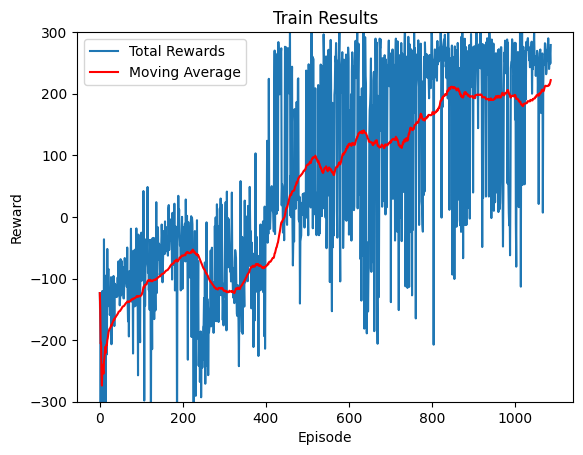

In [8]:
# plot the training process for the pre-trained model or your own model

plt.plot(total_rewards, label='Total Rewards')
plt.plot(moving_avg_rewards, color='red', label='Moving Average')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.ylim(-300, 300)
plt.title('Train Results')
plt.show()

# Testing

After loading the trained model, the expected test result is success rate around 90%.

In [9]:
# load the pretrained model
# you may skip this part if you want to test your own model

policy.load_state_dict(torch.load('trained_model'))

<All keys matched successfully>

  0%|          | 0/500 [00:00<?, ?it/s]

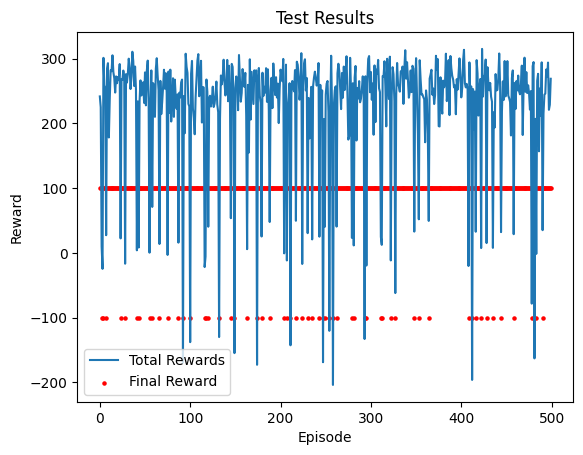

0.88


In [10]:
# test the model

test_total_rewards = []
test_final_rewards = []
step_used_list = []
test_number = 500
prg_bar = tqdm(range(test_number))
for i in prg_bar:
    actions = []
    state = env.reset()[0]
    total_reward = 0
    done = False
    step = 0
    while not done :
        state = np.append(state, step/500)
        step +=1
        action = policy(state)
        actions.append(action)
        state, reward, done, _, _ = env.step(action)
        total_reward += reward
    test_total_rewards.append(total_reward)
    test_final_rewards.append(reward)
    step_used_list.append(step)

plt.plot([i for i in range(test_number)],test_total_rewards, label='Total Rewards')
plt.scatter([i for i in range(test_number)],test_final_rewards,c='r', s = 5, label='Final Reward')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Test Results')
plt.show()
print(test_final_rewards.count(100)/test_number)

# Visualize Landing

Reward: 242.5126861564623


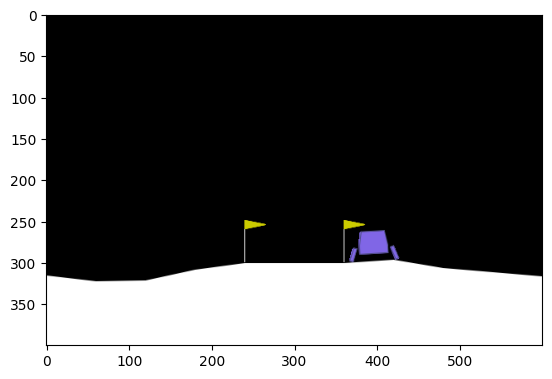

In [16]:
# visualize the landing process

fig = plt.figure()
env.reset()
img = plt.imshow(env.render())

render = True
save_gif = False
done = False

for i_episode in range(1):
    ims = []
    state,_ = env.reset()
    running_reward = 0
    step = 0
    while not done:
        state = np.append(state, step/500)
        action = policy(state)
        state, reward, done,_ , _ = env.step(action)
        running_reward += reward
        step += 1
        img.set_data(env.render())
        im = plt.imshow(env.render(), animated=True)
        ims.append([im])
        # display.display(plt.gcf())
        # display.clear_output(wait=True)

    print('Reward: {}'.format(running_reward))
    ani = animation.ArtistAnimation(fig, ims, interval=25, blit=True, repeat_delay=1000)
env.close()


In [17]:
ani.save('A2C.gif')